In [ ]:
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import  pearsonr
import numpy as np
import matplotlib.pyplot as plt


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    print(fcd.shape)
    print(data.shape)
    print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd

from scipy.signal import find_peaks
def get_peak_and_ms(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_value = 0
        time = 0
    else:
        autocorr_value = autocorr[peaks[0]]
        time = peaks[0]
    return autocorr_value,time


nb_steps = 50000
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
# Load coefficients to estimte Decay with LR
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
C = 0.2*C/np.max(C)
triu_idx = np.triu_indices(C.shape[1],1)
brunout = 8
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
sampling_freq = 10000


G_max = 8
G_step = 0.25
G_range = np.arange(1,G_max,G_step)
LR_range = np.logspace(0, 3,100)

# Define the number of cores to use
NUM_CORES = 24
NREP = 8
peak_autocorrelation_grid = np.zeros((NREP,len(G_range),len(LR_range)))
peak_time_grid = np.zeros((NREP,len(G_range),len(LR_range)))
std_slow_grid = np.zeros((NREP,len(G_range),len(LR_range)))
corr_to_sc_grid = np.zeros((NREP,len(G_range),len(LR_range)))
homeostatic_fittness_grid = np.zeros((NREP,len(G_range),len(LR_range),params['N']))
rates_grid = np.zeros((NREP,len(G_range),len(LR_range),params['N']))
fic_t_grid = np.zeros((NREP,len(G_range),len(LR_range),params['N']))

params['with_plasticity'] = True
params['with_decay'] = True
params['return_bold'] = False
params['return_rate'] = True
params['return_fic'] = True


def grid_step(args):
    all_peak_autocorr = np.zeros((NREP))
    all_peak_time = np.zeros((NREP))
    all_corr = np.zeros((NREP))
    all_homfit = np.zeros((NREP, params['N']))
    all_rates = np.zeros((NREP, params['N']))
    all_fic_t = np.zeros((NREP, params['N'] ))


    G_tuple, LR_tuple = args
    idx_LR,LR = LR_tuple[0],LR_tuple[1]
    idx_G,G = G_tuple[0],G_tuple[1]
    DECAY = np.exp(a+np.log(LR)*b)
    OBJ_RATE = 3.44        
    params['lrj'] = LR
    params['G'] = G
    # Using heuristic linear rule 
    params['taoj'] = DECAY 
    params['obj_rate'] = OBJ_RATE
    #params['taoj'] = 210000
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    for idx in range(NREP):
        rates, _, _, fic_t = dmf.run(params, nb_steps)        
        rates = rates[:, np.ceil(brunout * 1000).astype(int):]    
        fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]    
        rates_fc = np.corrcoef(rates)
        all_rates[idx,:] = np.mean(rates, axis=1)
        all_fic_t[idx,:] = np.mean(fic_t, axis=1)
        corr_to_sc = pearsonr(rates_fc[triu_idx[0],triu_idx[1]], C[triu_idx[0],triu_idx[1]])[0]
        all_corr[idx] = corr_to_sc
        peak_autocorrelation,peak_time = get_peak_and_ms(rates)        
        all_peak_autocorr[idx] = peak_autocorrelation
        all_peak_time[idx] = peak_time
        homeostatic_fittness =  OBJ_RATE - np.mean(rates,axis=1)  
        all_homfit[idx, :] = np.mean(homeostatic_fittness)
    peak_autocorrelation = all_peak_autocorr
    peak_time = all_peak_time
    corr_to_sc = all_corr
    homeostatic_fittness = all_homfit
    rates = all_rates
    fic_t = all_fic_t  

    return idx_G,idx_LR, peak_autocorrelation,peak_time,corr_to_sc,homeostatic_fittness,rates,fic_t


from multiprocessing import Pool,Manager


# Define the number of cores to use

# Create a list of argument tuples for the nested loop function
args_list = [((idx_G,G), (idx_LR,LR))
             for idx_G,G in enumerate(G_range)             
             for idx_LR,LR in enumerate(LR_range)]

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes
with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))



for results in results_list:
    idx_G = results[0]    
    idx_LR = results[1]
    peak_autocorrelation = results[2]
    peak_time = results[3]    
    corr_to_sc = results[4]
    homeostatic_fittness = results[5]
    rates = results[6]
    fic_t = results[7]    
    peak_autocorrelation_grid[:,idx_G,idx_LR] = peak_autocorrelation
    peak_time_grid[:,idx_G,idx_LR] = peak_time        
    corr_to_sc_grid[:,idx_G,idx_LR] = corr_to_sc
    homeostatic_fittness_grid[:,idx_G,idx_LR] = homeostatic_fittness
    rates_grid[:,idx_G,idx_LR,:] = rates
    fic_t_grid[:,idx_G,idx_LR,:] = fic_t


    import os

# Assuming these arrays are already populated with data

arrays_to_save = {
    'peak_autocorrelation_grid': peak_autocorrelation_grid,
    'peak_time_grid': peak_time_grid,    
    'corr_to_sc_grid': corr_to_sc_grid,
    'homeostatic_fittness_grid': homeostatic_fittness_grid,
    'rates_grid': rates_grid,
    'fic_t_grid': fic_t_grid
}

results_folder = "./Results/slow_waves08"

# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)


In [25]:
import os
import numpy as np
arrays_to_save = [
    'peak_autocorrelation_grid',
    'peak_time_grid',    
    'corr_to_sc_grid',
    'homeostatic_fittness_grid',
    'rates_grid',
    'fic_t_grid']


results_folder = "./Results/slow_waves08"

results_08 = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    results_08[array_name] = np.load(file_name)

In [26]:
results_folder = "./Results/slow_waves816"

results_816 = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    results_816[array_name] = np.load(file_name)

In [27]:
results_816['corr_to_sc_grid'].shape

(8, 32, 100)

In [28]:
peak_autocorrelation_grid = np.concatenate([results_08['peak_autocorrelation_grid'],results_816['peak_autocorrelation_grid']], axis=1)
peak_time_grid = np.concatenate([results_08['peak_time_grid'],results_816['peak_time_grid']], axis=1)
corr_to_sc_grid = np.concatenate([results_08['corr_to_sc_grid'],results_816['corr_to_sc_grid']], axis=1)
homeostatic_fittness_grid = np.concatenate([results_08['homeostatic_fittness_grid'],results_816['homeostatic_fittness_grid']], axis=1)
rates_grid = np.concatenate([results_08['rates_grid'],results_816['rates_grid']], axis=1)
fic_t_grid = np.concatenate([results_08['fic_t_grid'],results_816['fic_t_grid']], axis=1)


In [35]:
fic_t_grid.shape

(8, 60, 100, 90)

In [ ]:
arrays_to_save = {
    'peak_autocorrelation_grid': peak_autocorrelation_grid,
    'peak_time_grid': peak_time_grid,    
    'corr_to_sc_grid': corr_to_sc_grid,
    'homeostatic_fittness_grid': homeostatic_fittness_grid,
    'rates_grid': rates_grid,
    'fic_t_grid': fic_t_grid
}

results_folder = "./Results/slow_waves"

# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)

In [31]:
G_max = 8
G_step = 0.25
G_range_8 = np.arange(1,G_max,G_step)
print(len(G_range_8))

28


In [32]:
G_max = 16
G_step = 0.25
G_range_16 = np.arange(8,G_max,G_step)
print(len(G_range_16))
LR_range = np.logspace(0, 3,100)

32


### ploteo

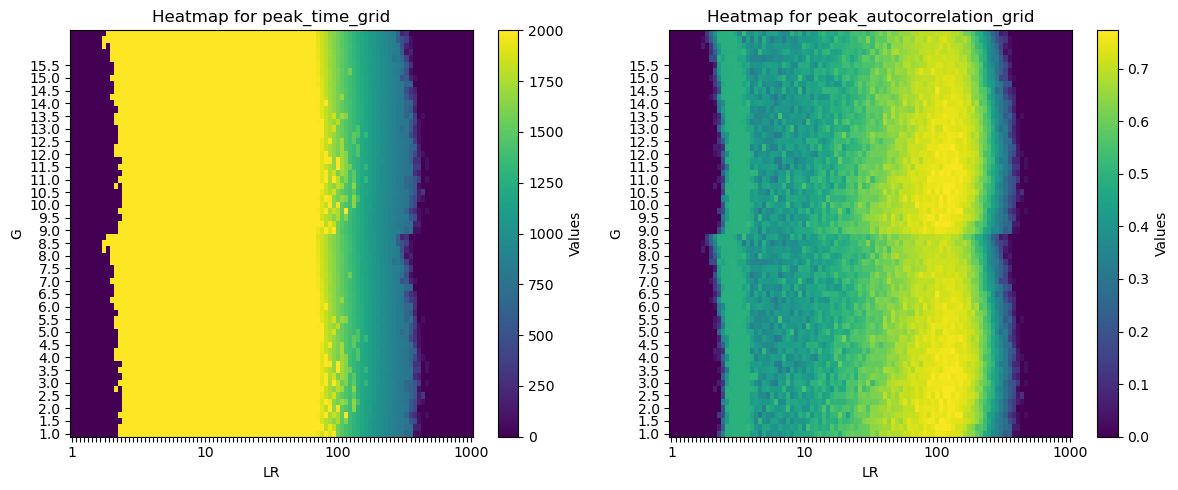

In [24]:

# Create subplots
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

G_max = 16
G_step = 0.25
G_range = np.arange(1,G_max,G_step)
LR_range = np.logspace(0, 3,100)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Heatmap for peak_time_grid
im1 = axes[0].imshow(np.mean(peak_time_grid,axis=0), cmap='viridis', origin='lower', aspect='auto', vmax=2000)
axes[0].set_title('Heatmap for peak_time_grid')
axes[0].set_xlabel('LR')
axes[0].set_ylabel('G')
# Set logarithmic tick labels for LR
log_labels = ['' for _ in range(len(LR_range))]
log_labels[0] = 1
log_labels[33] = 10
log_labels[66] = 100
log_labels[99] = 1000
axes[0].set_xticks(range(len(LR_range)))
axes[0].set_xticklabels(log_labels)
axes[0].set_yticks(range(0,60,2))
axes[0].set_yticklabels(G_range[range(0,60,2)])
plt.colorbar(im1, ax=axes[0], label='Values')
# Heatmap for peak_autocorrelation_grid
im2 = axes[1].imshow(np.mean(peak_autocorrelation_grid,axis=0), cmap='viridis', origin='lower', aspect='auto')
axes[1].set_title('Heatmap for peak_autocorrelation_grid')
axes[1].set_xlabel('LR')
axes[1].set_ylabel('G')
axes[1].set_xticks(range(len(LR_range)))
axes[1].set_xticklabels(log_labels)
axes[1].set_yticks(range(0,60,2))
axes[1].set_yticklabels(G_range[range(0,60,2)])
plt.colorbar(im2, ax=axes[1], label='Values')
plt.tight_layout()
plt.show()